<a href="https://colab.research.google.com/github/zabi-salehi/RL_6.Semester/blob/main/RL_super_mario_aufgabe3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Aufgabe 3 -  Hands-On Projekt: Training a Mario agent based on Reinforcement Learning

# References:
- DDQN Paper: (`<https://arxiv.org/pdf/1509.06461.pdf>`)
- https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html

- https://blog.paperspace.com/building-double-deep-q-network-super-mario-bros/
-  https://www.analyticsvidhya.com/blog/2021/06/playing-super-mario-bros-with-deep-reinforcement-learning/
-  https://medium.com/@sthacruz/build-your-own-reinforcement-learning-agent-that-plays-super-mario-2820a09676f1
-  https://medium.com/geekculture/a-simple-guide-to-reinforcement-learning-with-the-super-mario-bros-environment-495a13974a54



# Imports

In [ ]:
%matplotlib inline

In [ ]:
%%bash
pip install gym-super-mario-bros==7.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.2 MB/s eta 0:00:00
  Created wheel for nes-py: filename=nes_py-8.2.1-cp310-cp310-linux_x86_64.whl size=535679 sha256=fa72c1c21e5a6a57c55783b3335b11ad4060ad93adb36e08f57d35da73c4032d
  Stored in directory: /root/.cache/pip/wheels/34/a7/d5/9aa14b15df740a53d41f702e4c795731b6c4da7925deb8476c
Successfully built nes-py


In [ ]:
!pip install tensordict
!pip install torchrl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.1/130.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 13.7 MB/s eta 0:00:00


In [ ]:
# Standard library
import os
import random
import datetime
from collections import deque
from pathlib import Path
import copy

# External libraries
import torch
from torch import nn
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack
import numpy as np
from PIL import Image
import imageio
from IPython.display import Image
from torchvision import transforms as T

# Wrappers
from nes_py.wrappers import JoypadSpace

# Game environment
import gym_super_mario_bros


# Initialize Environment

Environment consists of tubes, mushrooms and other
components.

When Mario makes an action, the environment responds with the changed
(next) state, reward and other info.




In [ ]:
# Initialize Super Mario environment
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")

# Limit the action-space to
#   0. walk right
#   1. jump right
env = JoypadSpace(env, [["right"], ["right", "A"]])

env.reset()
next_state, reward, done, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(


(240, 256, 3),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


Preprocess Environment
------------------------

Environment data is returned to the agent in ``next_state``. As you saw
above, each state is represented by a ``[3, 240, 256]`` size array. with 3 representing the rgb color, and 240, 256 representing the height and with respectively.
We can reduce the rgb color to just grey, since marios actions do not depend on the color of anything.

Use **Wrappers** to preprocess environment data before sending it to
the agent.

``GrayScaleObservation`` is a common wrapper to transform an RGB image
to grayscale; doing so reduces the size of the state representation
without losing useful information. Now the size of each state:
``[1, 240, 256]``

``ResizeObservation`` downsamples each observation into a square image.
New size: ``[1, 84, 84]``

``SkipFrame`` is a custom wrapper that
implements the ``step()`` function. Because consecutive frames don’t
vary much, we can skip n-intermediate frames without losing much
information. The n-th frame aggregates rewards accumulated over each
skipped frame.

``FrameStack`` is a wrapper that allows us to squash consecutive frames
of the environment into a single observation point to feed to our
learning model. This way, we can identify if Mario was landing or
jumping based on the direction of his movement in the previous several
frames.




In [ ]:
class SkipFrame(gym.Wrapper):

    """
    Wrapper to skip frames in the environment. The class enables to return
    frames only at every 'skip'-th step
    """

    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):

        """
        Override step to repeat action, and sum reward
        It returns the total reward for those skipped frames
        and the information for the last frame
        """

        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    """
    Wrapper to convert an image observation to grayscale. The class
    changes the observation_space to apply the transformation
    """
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        """
        Change the observation array to tensor to use gray scale transformation
        """
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):

        """
        Override observation and apply the permute and grayscale transformation
        """
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):

    """
    Wrapper to resize the observations from the environment
    """
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):

        """
        Override observation and apply resizing and normalization to the observation
        """
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

The agent's state is represented by frames of the game that are preprocessed by skipping unnecessary frames, grayscale conversion and resizing to a 84x84 size frame. Furthermore, to introduce the concept of temporal abstraction, frames are then stacked together to create a state tensor with 4 consecutive frames.  Every time that Mario makes an action, the environment responds with a state of the structure of a 3-D array of size ``[4, 84, 84]``.


# Agent


Create class ``Mario`` to represent our agent in the game. Mario
should be able to:

-  **Act** according to the optimal action policy based on the current
   state (of the environment).

-  **Remember** experiences. Experience = (current state, current
   action, reward, next state). Mario *caches* and later *recalls* his
   experiences to update his action policy.

-  **Learn** a better action policy over time




In [ ]:
class Mario:
    def __init__():
        pass

    def act(self, state):
        """Given a state, choose an epsilon-greedy action"""
        pass

    def cache(self, experience):
        """Add the experience to memory"""
        pass

    def recall(self):
        """Sample experiences from memory"""
        pass

    def learn(self):
        """Update online action value (Q) function with a batch of experiences"""
        pass

In the following sections, we will populate Mario’s parameters and
define his functions.




Act
--------------

For any given state, an agent can choose to do the most optimal action
(**exploit**) or a random action (**explore**).

Mario randomly explores with a chance of ``self.exploration_rate``; when
he chooses to exploit, he relies on ``MarioNet`` (implemented in
``Learn`` section) to provide the most optimal action.




In [ ]:
class Mario:

    """
    Creating a Mario class which includes the definition for Mario's action choices
    and implementation of epsilon-greedy strategy.
    """
    def __init__(self, state_dim, action_dim, save_dir):

        """
        Initialize a Mario class object.

        Args:
        state_dim : State dimensions
        action_dim : Action dimensions
        save_dir : Directory for saving data
        """
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        self.use_cuda = torch.cuda.is_available()

        # Mario's DNN to predict the most optimal action -  this is implemented in the Learn section
        self.net = MarioNet(self.state_dim, self.action_dim).float()
        if self.use_cuda:
            self.net = self.net.to(device="cuda")

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        # Number of experiences between saving Mario Net
        self.save_every = 5e5
    def act(self, state):
        """
    Given a state, choose an epsilon-greedy action and update value of step.

    Inputs:
    state(LazyFrame): A single observation of the current state, dimension is (state_dim)
    Outputs:
    action_idx (int): An integer representing which action Mario will perform
    """
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # EXPLOIT
        else:
            state = state.__array__()
            if self.use_cuda:
                state = torch.tensor(state).cuda()
            else:
                state = torch.tensor(state)
            state = state.unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx

Cache and Recall
----------------------

These two functions serve as Mario’s “memory” process.

``cache()``: Each time Mario performs an action, he stores the
``experience`` to his memory. His experience includes the current
*state*, *action* performed, *reward* from the action, the *next state*,
and whether the game is *done*.

``recall()``: Mario randomly samples a batch of experiences from his
memory, and uses that to learn the game.




In [ ]:
class Mario(Mario):  # subclassing for continuity
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.memory = deque(maxlen=100000)
        self.batch_size = 32

    def cache(self, state, next_state, action, reward, done):
        """
        Store the experience to self.memory (replay buffer)

        Inputs:
        state (LazyFrame),
        next_state (LazyFrame),
        action (int),
        reward (float),
        done(bool))
        """
        state = state.__array__()
        next_state = next_state.__array__()

        if self.use_cuda:
            state = torch.tensor(state).cuda()
            next_state = torch.tensor(next_state).cuda()
            action = torch.tensor([action]).cuda()
            reward = torch.tensor([reward]).cuda()
            done = torch.tensor([done]).cuda()
        else:
            state = torch.tensor(state)
            next_state = torch.tensor(next_state)
            action = torch.tensor([action])
            reward = torch.tensor([reward])
            done = torch.tensor([done])

        self.memory.append((state, next_state, action, reward, done,))

    def recall(self):
        """
        Retrieve a batch of experiences from memory
        """
        batch = random.sample(self.memory, self.batch_size)
        state, next_state, action, reward, done = map(torch.stack, zip(*batch))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

Learn
--------------

Mario uses the `DDQN algorithm <https://arxiv.org/pdf/1509.06461>` under the hood. DDQN uses two ConvNets - $Q_{online}$ and
$Q_{target}$ - that independently approximate the optimal
action-value function.

In our implementation, we share feature generator ``features`` across
$Q_{online}$ and $Q_{target}$, but maintain separate FC
classifiers for each. $\theta_{target}$ (the parameters of
$Q_{target}$) is frozen to prevent updation by backprop. Instead,
it is periodically synced with $\theta_{online}$ (more on this
later).

# Neural Network




In [ ]:
class MarioNet(nn.Module):
    """mini cnn structure
    input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output

    This class is used for creating MarioNet
    """

    def __init__(self, input_dim, output_dim):
        """
        Initialize MarioNet

        Args:
        input_dim: The dimension of the input tensor
        output_dim: The dimension of the output tensor
        """
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

        self.target = copy.deepcopy(self.online)

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        """
        Forward pass through network

        Args:
        input: The input tensor
        model: The model to use, 'online' or 'target'
        """
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

## TD Estimate & TD Target


Two values are involved in learning:

**TD Estimate** - the predicted optimal $Q^*$ for a given state.

**TD Target** - aggregation of current reward and the estimated
$Q^*$ in the next state $s'$.



Because we don’t know what next action $a'$ will be, we use the
action $a'$ maximizes $Q_{online}$ in the next state
$s'$.

Notice we use the
`@torch.no_grad() <https://pytorch.org/docs/stable/generated/torch.no_grad.html#no-grad>`__
decorator on ``td_target()`` to disable gradient calculations here
(because we don’t need to backpropagate on $\theta_{target}$).




In [ ]:
class Mario(Mario):

    """
    This is a class for Mario with Temporal Difference estimate and target methods.

    Attributes:
        state_dim : The state dimensions
        action_dim : The action dimensions
        save_dir : The directory to save data
        gamma : The discount factor for future rewards
    """
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.gamma = 0.9

    def td_estimate(self, state, action):
        """
        Compute the Temporal Difference estimate.
        Args:
            state (np.array): The state of the game
            action : The action taken
        Returns:
            current_Q : The Temporal Difference estimate
        """
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        """
        Compute the Temporal Difference target.
        Args:
            reward (float): The reward after taking an action
            next_state (np.array): The state of the game after taking an action
            done (bool): Whether the game is finished or not

        Returns:
            float: The Temporal Difference target
        """
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

# Updating the model








In [ ]:
class Mario(Mario):
    """
    Class for creating a Mario object with optimization utilities for Q-learning.
    """
    def __init__(self, state_dim, action_dim, save_dir):

        """Initialize the Mario object.

        Args:
        state_dim : Dimension of the state
        action_dim : Dimension of the action
        save_dir : Directory to save the data
        """
        super().__init__(state_dim, action_dim, save_dir)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()

    def update_Q_online(self, td_estimate, td_target):
        """Perform a Q update based on the Temporal Difference estimate and target.

        Args:
        td_estimate : Temporal Difference estimate
        td_target : Temporal Difference target

        Returns:
        float : Loss value calculated
        """
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        """
        Synchronize the Q target network parameters with the online network.
        """
        self.net.target.load_state_dict(self.net.online.state_dict())

#Save checkpoint





In [ ]:
class Mario(Mario):
    def save(self):
        save_path = (
            self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")

# Put everything together

In [ ]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.burnin = 1e4  # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_online
        self.sync_every = 1e4  # no. of experiences between Q_target & Q_online sync

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate
        td_est = self.td_estimate(state, action)

        # Get TD Target
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

Logging
--------------




In [ ]:
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt


class MetricLogger:
    """
    A class used to log metrics
    """
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        """
        Log metrics at each step.

        Args:
        reward : Reward at the current step
        loss : Loss at the current step
        q : Q-value at the current step
        """
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        """
        Mark end of episode and append current episode metrics to episode metrics history
        """
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        """
        Initialize metrics for a new episode.
        """
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        """
        Record averaged metrics and print them out.

        Args:
        episode : Episode number
        epsilon : Current epsilon
        step : Current step
        """
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_rewards", "ep_lengths", "ep_avg_losses", "ep_avg_qs"]:
            plt.plot(getattr(self, f"moving_avg_{metric}"))
            plt.savefig(getattr(self, f"{metric}_plot"))
            plt.clf()

# Train and Test the agent


## some necessary installations (for visualization purposes on colab) and imports

In [ ]:
%%capture
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip install pyvirtualdisplay
!pip install pyglet==1.5.1

!sudo apt-get update
!sudo apt-get install -y freeglut3-dev


In [ ]:
#

# Virtual display
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [ ]:
import os
from pathlib import Path
import datetime

import cv2
import numpy as np
import torch
import imageio
from IPython.display import Image
import gym
from gym.spaces import Box
from gym import Wrapper
import gym_super_mario_bros

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Train the agent and record video from the progress

In [ ]:
# The directory to be created
videos_dir = "/content/videos"

# Check if the directory exists
if not os.path.exists(videos_dir):
    # If not, create the directory
    os.makedirs(videos_dir)

In [ ]:
record_every_n_episodes = 50
# Define the number of episodes you want the agent to run, 40000 is the recommended number for mario to truly learn
num_episodes = 100

def record_video(env, mario, file_path):
    done = False
    state = env.reset()
    frames = []
    while not done:
        action = mario.act(state)
        state, reward, done, info = env.step(action)
        env.render()
        frames.append(np.array(env.render(mode='rgb_array')))
    imageio.mimsave(file_path, frames, fps=30)

use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)

logger = MetricLogger(save_dir)


for episode in range(num_episodes):

    # Record a video every "record_every_n_episodes" episodes
    if episode % record_every_n_episodes == 0:
        video_path = os.path.join('./videos', f'mario_episode{episode}.gif')
        record_video(env, mario, video_path)
        Image(open(video_path, "rb").read())
        print("****" * 10)


    state = env.reset()

    # Play the game!
    while True:
        action = mario.act(state)
        next_state, reward, done, info = env.step(action)
        mario.cache(state, next_state, action, reward, done)
        q, loss = mario.learn()
        logger.log_step(reward, loss, q)
        state = next_state

        # Check if end of game
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if episode % 20 == 0:
        logger.record(episode=episode, epsilon=mario.exploration_rate, step=mario.curr_step)

# Save the model after all episodes are done
torch.save(mario, 'mario.pth')

Using CUDA: True



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want 

****************************************
Episode 0 - Step 1028 - Epsilon 0.9997430329895175 - Mean Reward 1246.0 - Mean Length 597.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 23.528 - Time 2023-07-30T08:17:09


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want 

****************************************
Episode 20 - Step 5419 - Epsilon 0.9986461670902125 - Mean Reward 660.524 - Mean Length 229.81 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 63.621 - Time 2023-07-30T08:18:12


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want 

****************************************
Episode 40 - Step 11509 - Epsilon 0.9971268849576908 - Mean Reward 712.537 - Mean Length 247.463 - Mean Loss 0.146 - Mean Q Value 0.254 - Time Delta 82.374 - Time 2023-07-30T08:19:35


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want 

****************************************
Episode 60 - Step 14288 - Epsilon 0.9964343715574028 - Mean Reward 667.213 - Mean Length 211.164 - Mean Loss 0.272 - Mean Q Value 1.2 - Time Delta 40.382 - Time 2023-07-30T08:20:15


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want 

****************************************
Episode 80 - Step 19609 - Epsilon 0.995109745805912 - Mean Reward 664.346 - Mean Length 216.84 - Mean Loss 0.311 - Mean Q Value 1.692 - Time Delta 80.09 - Time 2023-07-30T08:21:35


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<Figure size 640x480 with 0 Axes>

## Display some videos of the training progress

Episode: 0


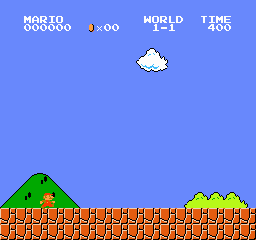

Episode: 20


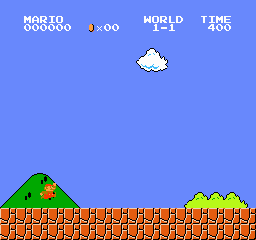

Episode: 40


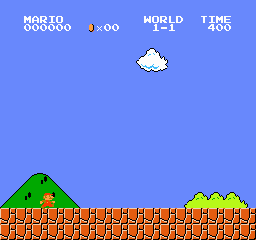

Episode: 60


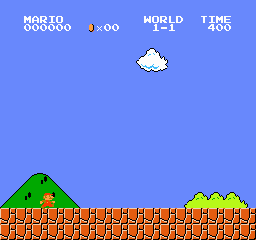

Episode: 80


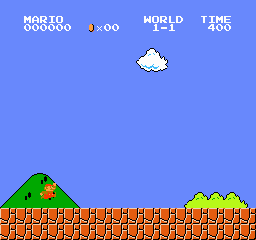

In [ ]:
import os
import re
from IPython.display import Image, display

# Get all the .gif files
files = [f for f in os.listdir("/content/videos") if f.endswith(".gif")]

# Sort the files based on the episode number in the name
files.sort(key=lambda x: int(re.search(r'(\d+)', x).group()))

# Display the files
for file in files:
    episode_num = re.search(r'(\d+)', file).group()  # Extract episode number from the filename
    print(f"Episode: {episode_num}")
    display(Image(open(f"/content/videos/{file}", "rb").read()))

## Display some graphs of the training progress

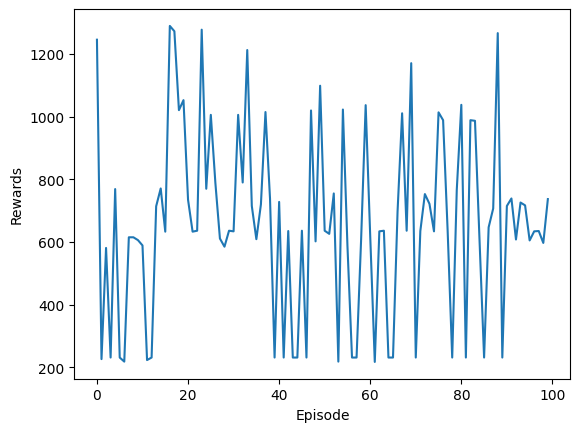

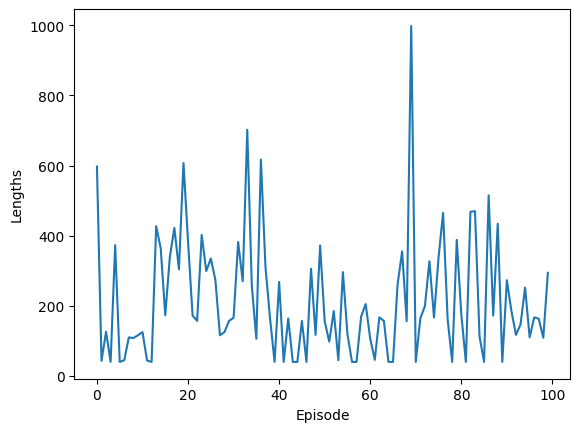

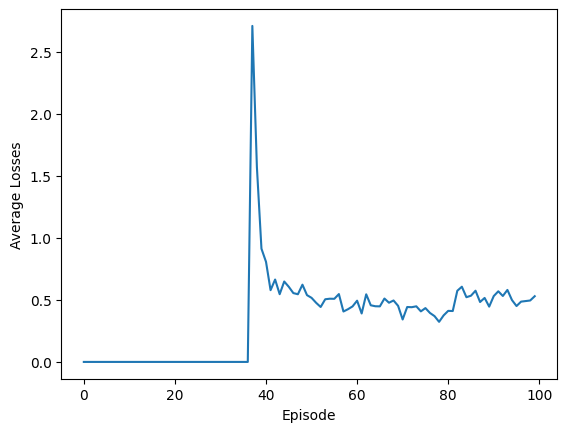

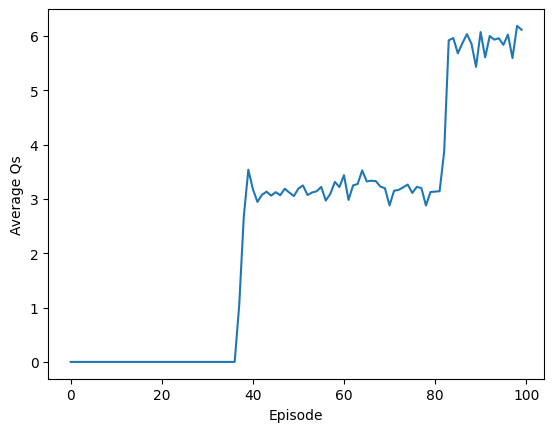

In [ ]:
import matplotlib.pyplot as plt

plt.plot(logger.ep_rewards)
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.show()

plt.plot(logger.ep_lengths)
plt.xlabel('Episode')
plt.ylabel('Lengths')
plt.show()

plt.plot(logger.ep_avg_losses)
plt.xlabel('Episode')
plt.ylabel('Average Losses')
plt.show()

plt.plot(logger.ep_avg_qs)
plt.xlabel('Episode')
plt.ylabel('Average Qs')
plt.show()